<h1>A / B Testing</h1>

<b>Description: </b>A fast-food chain plans to add a new item to its menu. However, they are still undecided between three possible marketing campaigns for promoting the new product. In order to determine which promotion has the greatest effect on sales, the new item is introduced at locations in several randomly selected markets. A different promotion is used at each location, and the weekly sales of the new item are recorded for the first four weeks. <br />

<b>Objective: </b>evaluate A/B testing results and decide which marketing strategy works the best.<br />

<b>Columns:</b><br />
MarketID: unique identifier for market<br />
MarketSize: size of market area by sales<br />
LocationID: unique identifier for store location<br />
AgeOfStore: age of store in years<br />
Promotion: one of three promotions that were tested<br />
week: one of four weeks when the promotions were run<br />
SalesInThousands: sales amount for a specific LocationID, Promotion, and week<br />

<b>Credentials:</b><br />
https://rpubs.com/ksdwivedy/finalRProject<br />
Hands-On Data Science for Marketing book by Yoon Hyup Hwang<br />
https://unsplash.com/@shaafi for the picture<br />
IBM Watson Analytics community for this dataset.<br />


In [2]:
# import packages
import numpy as np
import pandas as pd
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})

from scipy.stats import shapiro
from scipy.stats import mannwhitneyu
from scipy.stats import kruskal
from scikit_posthocs import posthoc_conover

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action="ignore", category=FutureWarning)

pd.set_option("display.max_columns", None)

<h3>Wrangling</h3>

In [3]:
# loading file
path = './data/raw/2/WA_Marketing-Campaign.csv'
df = pd.read_csv(path)
df

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands
0,1,Medium,1,4,3,1,33.73
1,1,Medium,1,4,3,2,35.67
2,1,Medium,1,4,3,3,29.03
3,1,Medium,1,4,3,4,39.25
4,1,Medium,2,5,2,1,27.81
...,...,...,...,...,...,...,...
543,10,Large,919,2,1,4,64.34
544,10,Large,920,14,2,1,50.20
545,10,Large,920,14,2,2,45.75
546,10,Large,920,14,2,3,44.29


In [4]:
# checking info of our dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548 entries, 0 to 547
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MarketID          548 non-null    int64  
 1   MarketSize        548 non-null    object 
 2   LocationID        548 non-null    int64  
 3   AgeOfStore        548 non-null    int64  
 4   Promotion         548 non-null    int64  
 5   week              548 non-null    int64  
 6   SalesInThousands  548 non-null    float64
dtypes: float64(1), int64(5), object(1)
memory usage: 30.1+ KB


In [5]:
# checking for uniqueness of each column
df.nunique()

MarketID             10
MarketSize            3
LocationID          137
AgeOfStore           25
Promotion             3
week                  4
SalesInThousands    517
dtype: int64

<b>Note: </b> we will be working with three different groups (promotions) to test our hypothesis.

In [6]:
# checking for missing values of each column
df.isnull().sum()

MarketID            0
MarketSize          0
LocationID          0
AgeOfStore          0
Promotion           0
week                0
SalesInThousands    0
dtype: int64

In [7]:
# checking for duplicates
print(f"# of duplacated rows: ", sum(df.duplicated()))

# of duplacated rows:  0


In [8]:
# converting 'SalesInThousands' into the proper unit
df['SalesInThousands'] = df['SalesInThousands'] * 1000
df.head(3)

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands
0,1,Medium,1,4,3,1,33730.0
1,1,Medium,1,4,3,2,35670.0
2,1,Medium,1,4,3,3,29030.0


<h3>EDA / Statistical Analysis</h3>

In [9]:
# checking how many stores were involved in each promotion
df.groupby('Promotion')['MarketSize'].agg(['count'])

,count
Promotion,
1,172
2,188
3,188


<b>Note: </b> we can see that all three promotions were 'almost' evenly distributed among three random markets. The only thing here is that the first promotion was less 'actively' used compared to the second and third ones.  

In [10]:
# checking which 'MarketSize' is more popular among all markets by the 'Promotion' column
df.groupby(['Promotion', 'MarketSize'])['LocationID'].agg(['count'])

count
Promotion MarketSize       
1         Large          56
          Medium         96
          Small          20
2         Large          64
          Medium        108
          Small          16
3         Large          48
          Medium        116
          Small          24

In [11]:
# show histogram based on the 'Promotion' column and one that is provided by the user
def show_hist(data, col_name, num_bins=0, is_kde=False):
    for i in range(1, 4):
        if num_bins == 0:
            _ = sns.histplot(data=df[df['Promotion'] == i], x=col_name, kde=is_kde)
        else:
            _ = sns.histplot(data=df[df['Promotion'] == i], x=col_name, bins=num_bins, kde=is_kde)
        _ = plt.title(f"HISTPLOT - '{col_name.upper()}' by promotion #'{i}'")
        _ = plt.ylabel("# of stores")
        plt.show()
        
    return None

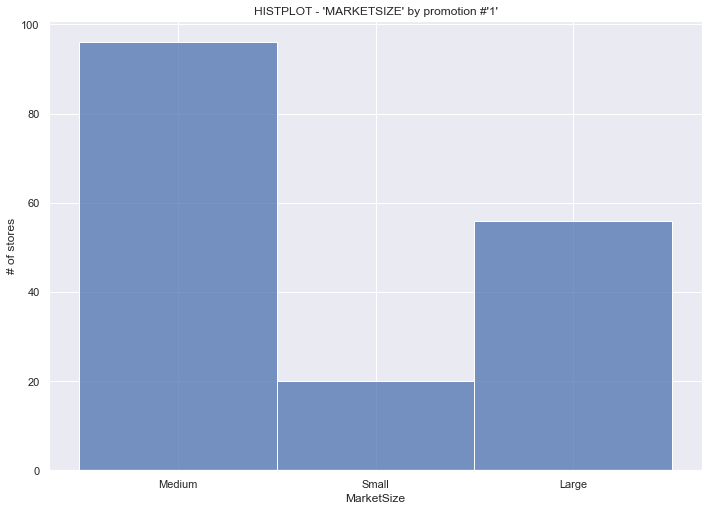

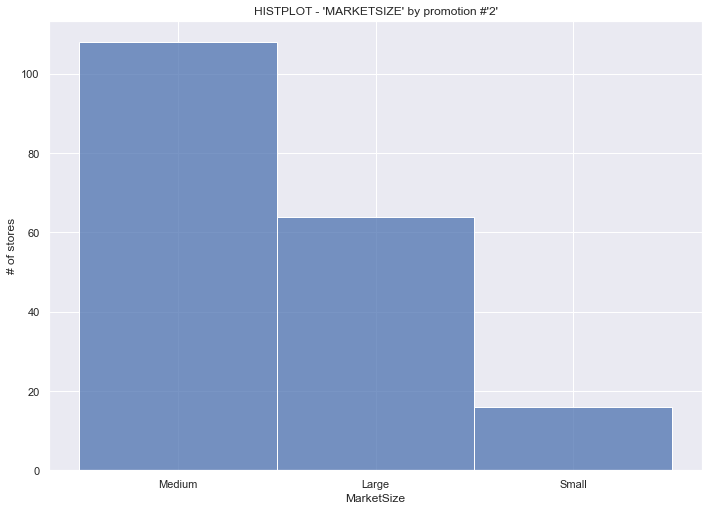

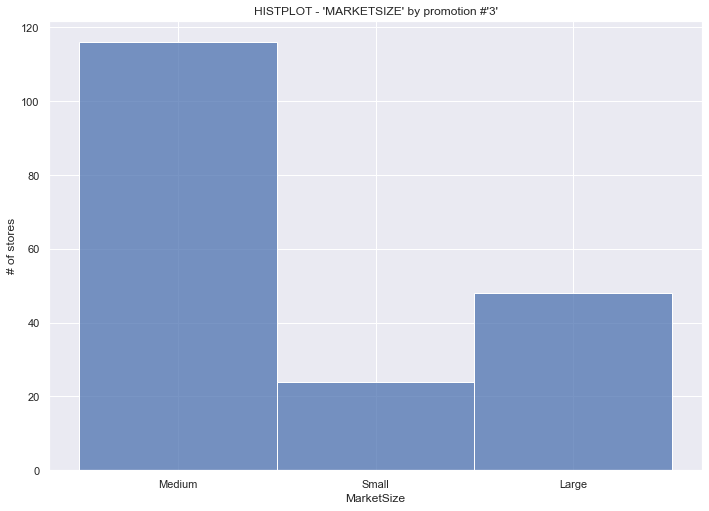

In [12]:
show_hist(df, 'MarketSize')

<b>Note: </b> we can see that the most popular size of the store in our dataset is 'medium' among all three promotions.

In [13]:
# checking the age of store
df.groupby(['Promotion', 'MarketSize'])['AgeOfStore'].agg(['min', 'max', 'median', "std"])

min  max  median        std
Promotion MarketSize                             
1         Large         1   24     3.0   6.863417
          Medium        1   27     7.5   6.144317
          Small         3   22     9.0   6.521220
2         Large         1   23     7.0   5.427370
          Medium        1   25     5.0   6.338551
          Small         1   28     4.5  11.278298
3         Large         1   19     4.5   5.603317
          Medium        1   24     8.0   6.836712
          Small         5   22     8.0   6.639801

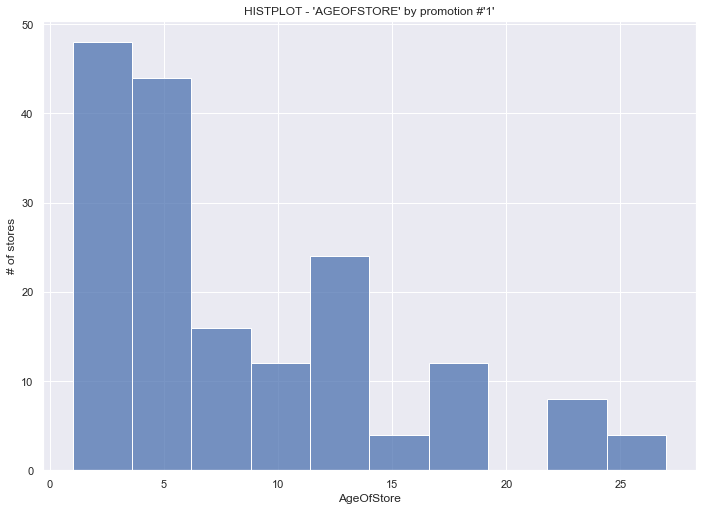

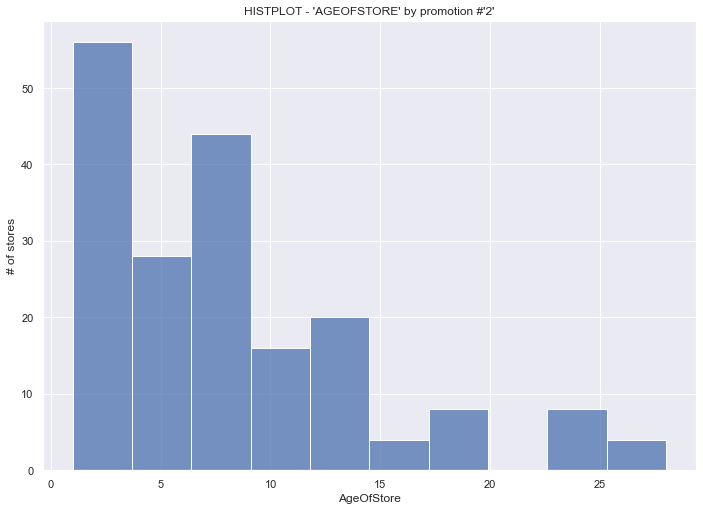

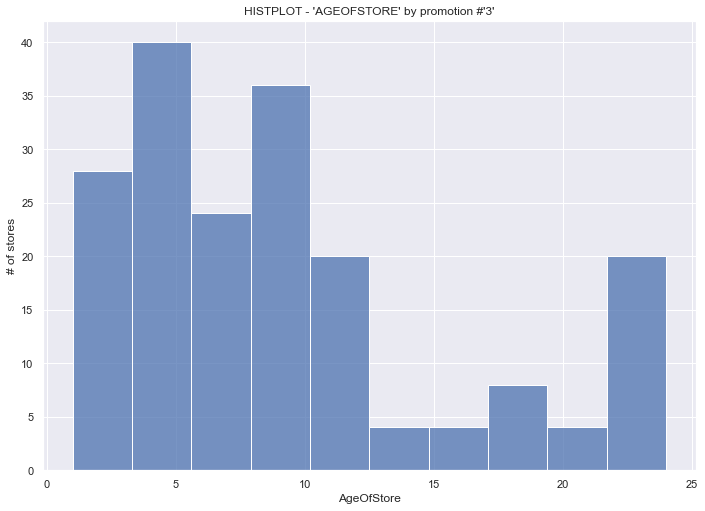

In [14]:
show_hist(df, 'AgeOfStore', 10)

<b>Note: </b> most of the stores fall within 4 to 9 years of being on the market.

In [15]:
# checking the summary of 'SalesInThousands' column by 'Promotion' columns
df.groupby(['Promotion'])['SalesInThousands'].agg(['count', 'min', 'max', 'mean', 'median', "std"])

,count,min,max,mean,median,std
Promotion,,,,,,
1,172,30810.0,99650.0,58099.011628,55385.0,16553.781698
2,188,17340.0,88640.0,47329.414894,45385.0,15108.954783
3,188,22180.0,96480.0,55364.468085,51165.0,16766.230774


<b>Note: </b> despite that, we have fewer stores that actively use promotion #1 we can state that promotion # 1 generates more profit than others (based on mean and median). But we will use statistics to test this hypothesis.

In [16]:
# checking the summary of 'SalesInThousands' column by 'Promotion' and 'MarketSize' columns
df.groupby(['Promotion', 'MarketSize'])['SalesInThousands'].agg(['count', 'min', 'max', 'median', "std"])

count      min      max   median           std
Promotion MarketSize                                                
1         Large          56  49620.0  99650.0  72835.0  15497.497015
          Medium         96  30810.0  65110.0  47425.0   8067.330511
          Small          20  51720.0  68420.0  61145.0   5127.278826
2         Large          64  39360.0  88640.0  53010.0  15728.529349
          Medium        108  17340.0  58100.0  39765.0   8807.406959
          Small          16  36170.0  61250.0  51600.0   5869.815975
3         Large          48  50050.0  96480.0  82345.0  14400.304184
          Medium        116  22180.0  64140.0  46295.0   8091.366174
          Small          24  46830.0  70600.0  59745.0   5212.686795

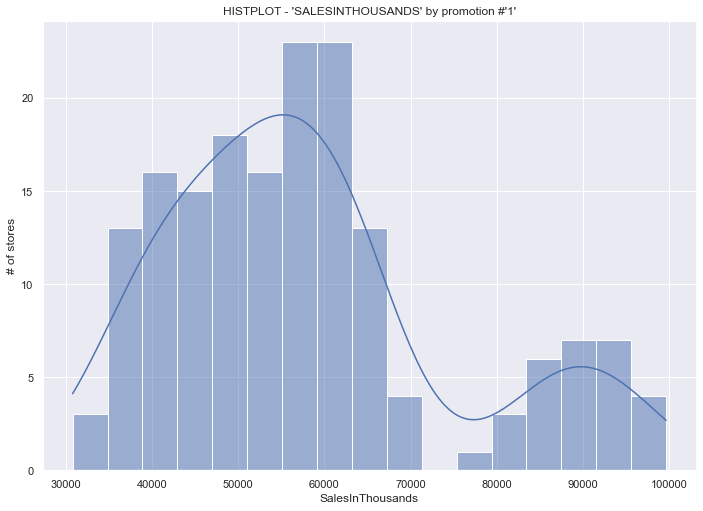

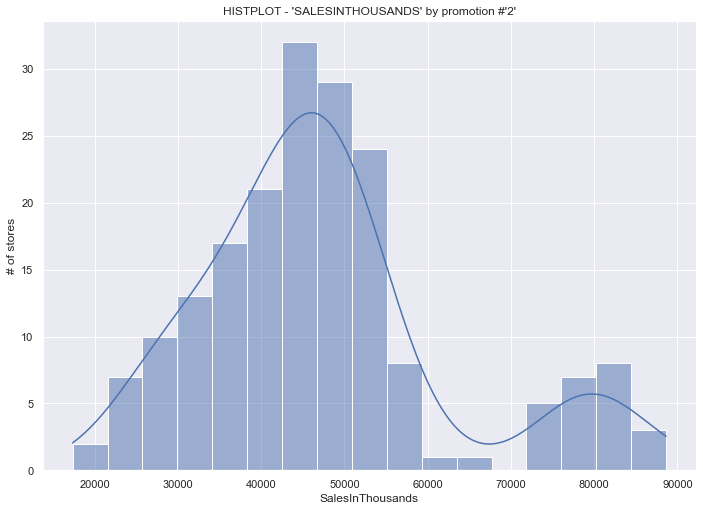

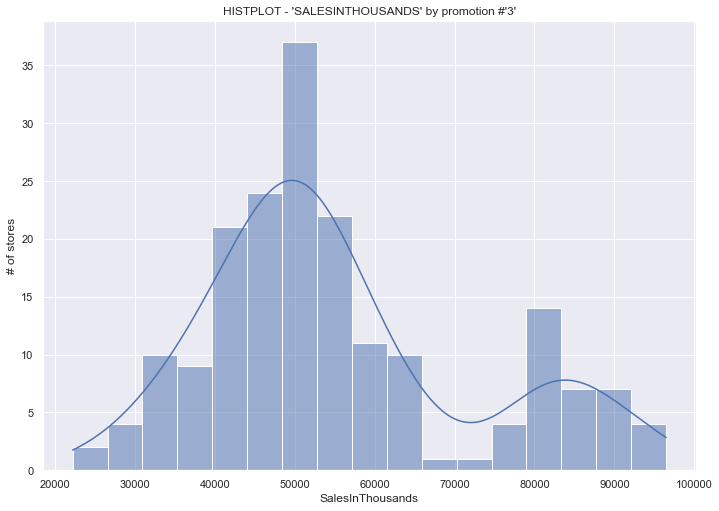

In [17]:
show_hist(df, 'SalesInThousands', 17, is_kde=True)

<b>Note: </b> we can see that "Promotion" by "SalesInThousands" columns are not 'normal distributed and follows the idea of 'Bimodal' distribution. We should note it while we are choosing how we are going to test our hypothesis.

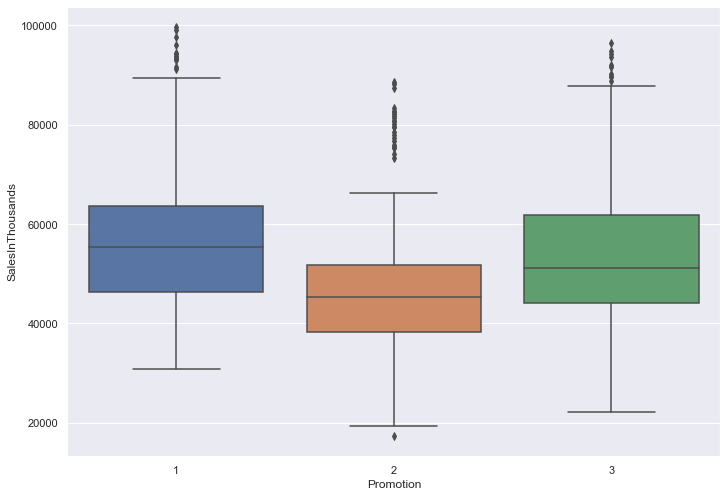

In [18]:
# checking for outliers
_ = sns.boxplot(data=df, x='Promotion', y='SalesInThousands')

<b>Note: </b> we can see from the boxplot that our data has outliers and is skewed to the right. There is a high chance that it will not pass the first test of Normality. So, we need to remove outliers before we will proceed to the next step.

In [19]:
# function to remove outliers using IQR approach (we are using this approach because our data is not normally distributed)
# https://www.geeksforgeeks.org/interquartile-range-to-detect-outliers-in-data/
def remove_outliers(data, col_name):
    # dealing with outliers for different each 'group' (promotion)
    df_promotion_by_group = data[data['Promotion'] == col_name]
    df_promotion_by_group = df_promotion_by_group.sort_values(by='SalesInThousands')

    # calculating Q1, Q2, Q3 and IQR
    Q1 = np.percentile(df_promotion_by_group['SalesInThousands'], 25, interpolation='midpoint')
    Q2 = np.percentile(df_promotion_by_group['SalesInThousands'], 50, interpolation='midpoint')
    Q3 = np.percentile(df_promotion_by_group['SalesInThousands'], 75, interpolation='midpoint')

    # calculating IQR
    IQR = Q3 - Q1

    # finding the lower and upper limits respectively
    low_lim = Q1 - 1.5 * IQR
    up_lim = Q1 + 1.5 * IQR

    return df_promotion_by_group[(df_promotion_by_group['SalesInThousands'] >= low_lim) & (df_promotion_by_group['SalesInThousands'] <= up_lim)]

In [20]:
# removing outliers for each group (promotion)
group_A = remove_outliers(df, 1)
group_B = remove_outliers(df, 2)
group_C = remove_outliers(df, 3)

group_A.shape, group_B.shape, group_C.shape

((144, 7), (162, 7), (152, 7))

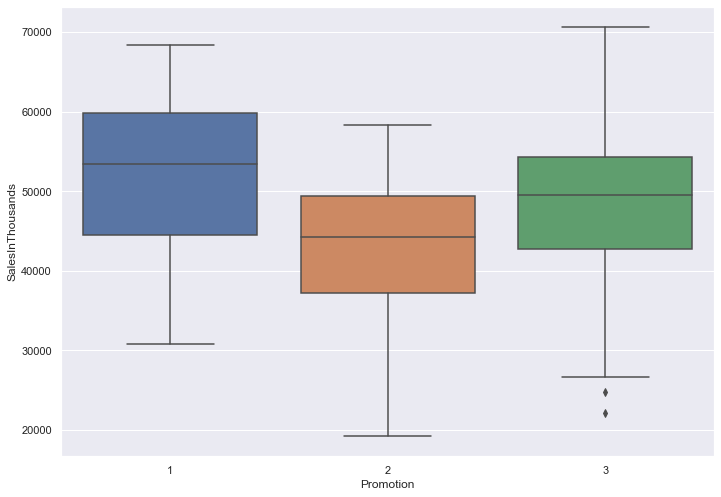

In [21]:
# verifying that our data now is less affected by outliers
df_no_outliers = pd.concat([group_A, group_B, group_C])
_ = sns.boxplot(data=df_no_outliers, x='Promotion', y='SalesInThousands')

<b>Note: </b> now our data is clean and we are ready to proceed with the hypothesis testing part.

<h3>A / B Testing</h3>

![A/B - Testing](./imgs/3.png "A/B Testing")

<b>Note: </b> two things we should mention before we will proceed with our hypothesis testing. First of all, we are working with continuous value  ('SalesInThousands' column). Secondly, we do have a large sample size (n>30). Knowing all of these, we can move to the first assumption of the Parametric Test that independently collected samples are following the rule of normality.

In [22]:
# preparing our data by storing it into three  separate groups for further evaluation
group_A = group_A['SalesInThousands']
group_B = group_B['SalesInThousands']
group_C = group_C['SalesInThousands']

group_A.shape, group_B.shape, group_C.shape

((144,), (162,), (152,))

In [23]:
# checking for Normality using the Shapiro-Wilk test
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html
for index, i in enumerate([group_A, group_B, group_C]):
    shapiro_stat, shapiro_p_value = shapiro(group_A)
    if shapiro_p_value <= 0.05:
        print(f"Promotion #{index+1}")
        print(f"P_value: {round(shapiro_p_value, 5)}")
        print(f"We REJECT the null hypothesis that the data was drawn from a normal distribution.\n")
    else:
        print(f"Promtion {index+1}")
        print(f"P_value: {round(shapiro_p_value, 5)}")
        print(f"We FAIL to reject the null hypothesis that the data was drawn from a normal distribution.\n")

Promotion #1
P_value: 0.00222
We REJECT the null hypothesis that the data was drawn from a normal distribution.

Promotion #2
P_value: 0.00222
We REJECT the null hypothesis that the data was drawn from a normal distribution.

Promotion #3
P_value: 0.00222
We REJECT the null hypothesis that the data was drawn from a normal distribution.



<b>Note: </b> as we can see all three samples are failed the normality test. Thereby, we will be using a Non-Parametric Test to answer our question if those samples (promotions) have medians that are statistically different from each other. 

In [24]:
# performing the Mann-Whitney U rank test on two independent samples
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html
list_of_group_combinations = [((group_A, 'group_A'), (group_B, 'group_B')),
                             ((group_A, 'group_A'), (group_C, 'group_C')),
                             ((group_B, 'group_B'), (group_C, 'group_C'))]

for i in list_of_group_combinations:
    mw_stat, mw_p_value = mannwhitneyu(i[0][0], i[1][0])
    
    if mw_p_value <= 0.05:
        print(f"{i[0][1]} vs {i[1][1]}")
        print(f"P_value: {round(mw_p_value, 5)}")
        print(f"We REJECT the null hypothesis that the distribution underlying sample x is the same as the distribution underlying sample y.\n")
    else:
        print(f"{i[0][1]} vs {i[1][1]}")
        print(f"P_value: {round(mw_p_value, 5)}")
        print(f"We FAILED to reject the null hypothesis that the distribution underlying sample x is the same as the distribution underlying sample y.\n")
    

group_A vs group_B
P_value: 0.0
We REJECT the null hypothesis that the distribution underlying sample x is the same as the distribution underlying sample y.

group_A vs group_C
P_value: 0.00082
We REJECT the null hypothesis that the distribution underlying sample x is the same as the distribution underlying sample y.

group_B vs group_C
P_value: 0.0
We REJECT the null hypothesis that the distribution underlying sample x is the same as the distribution underlying sample y.



![A/B - Testing](./imgs/4.png "A/B Testing")

In [25]:
# using one-way Anova to confirm our results: The Kruskal-Wallis H-test
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kruskal.html
kruskal_stat, kruskal_p_value = kruskal(group_A, group_B, group_C)
if kruskal_p_value <= 0.05:
    print(f"P_value: {round(kruskal_p_value, 5)}")
    print(f"We REJECT the null hypothesis that the population median of all of the groups are equal.")
else:
    print(f"P_value: {round(kruskal_p_value, 5)}")
    print(f"We FAILE to reject the null hypothesis that the population median of all of the groups are equal.")

P_value: 0.0
We REJECT the null hypothesis that the population median of all of the groups are equal.


In [26]:
# to learn what groups (promotions) differ in their medians we need to run post hoc tests (non-parametric test).
posthoc_conover(df_no_outliers, val_col='SalesInThousands', group_col='Promotion')

,1,2,3
1,1.000000e+00,3.030824e-16,1.901511e-03
2,3.030824e-16,1.000000e+00,1.130608e-07
3,1.901511e-03,1.130608e-07,1.000000e+00


<b>Note: </b> comparisons show that we may reject the null hypothesis (p < 0.05) for each pair of groups and conclude that all groups (promotions) differ in their effectiveness.

In [27]:
# looking at stats (mean/median) of "SalesInThousands" by different groups ("Promotions")
df_no_outliers.groupby('Promotion')['SalesInThousands'].agg(['median', 'mean'])

,median,mean
Promotion,,
1,53445.0,51964.652778
2,44225.0,42648.950617
3,49510.0,48364.078947


In [28]:
# calculating the ratio of median devided by sum for each group
def median_ration(data, group_name):
    group_median = df_no_outliers[df_no_outliers['Promotion'] == group_name]['SalesInThousands'].median()
    group_sum = df_no_outliers[df_no_outliers['Promotion'] == group_name]['SalesInThousands'].sum()
    
    return group_median / group_sum * 100

In [29]:
group_A_ratio = median_ration(df_no_outliers, 1)
group_B_ratio = median_ration(df_no_outliers, 2)
group_C_ratio = median_ration(df_no_outliers, 3)

print(f"Group_A 'promotion #1' has more effect than group_B 'promotion #2' by: {round(group_A_ratio - group_B_ratio, 3)}%")
print(f"Group_A 'promotion #1' has more effect than group_C 'promotion #3' by: {round(group_A_ratio - group_C_ratio, 3)}%")

Group_A 'promotion #1' has more effect than group_B 'promotion #2' by: 0.074%
Group_A 'promotion #1' has more effect than group_C 'promotion #3' by: 0.041%


<h3>Summary:</h3>

We have completed two Non-Parametric Tests:
<ul>
    <li>the Mann-Whitney U rank test on pair groups individually (including all combinations);</li>
    <li>The Kruskal-Wallis H-test with the combination of post hoc tests;</li>
</ul>
<b>Answer to our client: </b>promotion # 1 has more impact compared to others by 0.074% and 0.041% respectively.<br/ ><br/ >
<b>Statistical advice: </b>given the data, and performed tests, we advise using promotion # 1.<br/ ><br/ >
<b>Suggestions: </b>the experiment could be extended for a longer time, so we can gain more data and have statistically more accurate results.